# **SMU Course Bidding Data Preprocessing**

<div style="background-color:#DFFFD6; padding:12px; border-radius:5px; border: 1px solid #228B22;">
    
  <h2 style="color:#006400;">✅ Looking to Implement This? ✅</h2>
  
  <p>🚀 Get started quickly by using <strong><a href="example_prediction.ipynb">example_prediction.ipynb</a></strong>.</p>
  
  <ul>
    <li>📌 **Pre-trained CatBoost model (`.cbm`) available for instant predictions.**</li>
    <li>🔧 Includes **step-by-step instructions** for making predictions.</li>
    <li>⚡ Works **out-of-the-box**—just load the model and start predicting!</li>
  </ul>

  <h3>🔗 📌 Next Steps:</h3>
  <p>👉 <a href="example_prediction.ipynb"><strong>Go to Example Prediction Notebook</strong></a></p>

</div>

### **Changes in V4**
- Replaced `BidderCount` with `Before Process Vacancy` due to future dependent results like `After Process Vacancy` which is not available at prediction time.
- Development of two models, one for `Median Bid Price` and `Min Bid Price`.
- Refined model input to make ingesting data for prediction easier. No label encoding done for `Term` or `Round`.

### **Objective**
This notebook performs the following steps:
1. **Data Cleaning** - Handle redundant columns and remove unwanted data.
2. **Feature Engineering** - Create derived features.
3. **Exploratory Data Analysis (EDA)** - Analyze key features and outlier cleaning.
4. **Save Processed Data** - Save the data into a csv that is useable for other ML models

### **Requirements**
- Python 3.x
- TensorFlow, Pandas, NumPy, Matplotlib, Seaborn, Sklearn

---


---

## **1. Setup**

In [ ]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import StandardScaler
from typing import Dict, List, Tuple, Optional, Union
import warnings
warnings.filterwarnings('ignore')


---

## **2. SMUBiddingTransformer Class**

### **SMU Bidding Data Feature Engineering Transformer**

#### **What This Code Does**
The `SMUBiddingTransformer` class is a comprehensive feature engineering pipeline designed specifically for Singapore Management University (SMU) course bidding data and optimized for CatBoost model training. It transforms raw tabular bidding data into machine learning-ready features while preserving categorical features where beneficial for CatBoost and creating embeddings only for high-cardinality features.

**Key Features:**
- **CatBoost-Optimized**: Preserves categorical features in their natural form for CatBoost's superior categorical handling while creating embeddings only for high-cardinality features (instructors, day combinations)
- **Feature Type Tracking**: Automatically categorizes features into categorical, numeric, and embedding types with dedicated getter methods for each
- **Smart Missing Value Handling**: Configurable approach to missing values - either let CatBoost handle them natively or create embeddings for missing data
- **High-Cardinality Embeddings**: Creates dense vector representations of instructor names (1000+ unique) and day-of-week combinations using TF-IDF + SVD
- **Course Code Intelligence**: Parses various course code formats including hyphenated codes ('COR-COMM175') and standard formats ('MGMT715')
- **Bidding Window Parsing**: Extracts round numbers (including 1A, 1B, 2A formats) and window numbers from complex bidding window strings
- **Categorical Preservation**: Keeps start_time, term, course_name, subject_area as categorical for CatBoost's target encoding
- **Sklearn-Compatible**: Standard transformer interface with `fit()`, `transform()`, and `fit_transform()` methods

#### **What Is Required**

**Input Data Format:**
The transformer expects a pandas DataFrame with these **required columns**:
- `course_code` (str): Course identifier (e.g., 'MGMT715', 'COR-COMM175')
- `course_name` (str): Full course name
- `acad_year_start` (int): Academic year start (e.g., 2025)
- `term` (str): Academic term ('1', '2', '3A', '3B')
- `start_time` (str): Class start time (e.g., '19:30', 'TBA') - preserved as categorical
- `day_of_week` (str): Days of week, can be comma-separated (e.g., 'Mon,Thu')
- `before_process_vacancy` (int): Number of available vacancies
- `bidding_window` (str): Bidding window descriptor (e.g., 'Round 1 Window 1', 'Incoming Freshmen Rnd 1 Win 4')
- `instructor` (str): Instructor names, can be comma-separated (e.g., 'JOHN DOE, JANE SMITH')

**Technical Dependencies:**
- Python packages: `pandas`, `numpy`, `sklearn` (TfidfVectorizer, TruncatedSVD)
- Standard libraries: `typing`, `warnings`, `re`

**Configuration Parameters:**
- `n_instructor_components` (int, default=50): Embedding dimensions for instructor names (expected 1000+ unique instructors)
- `n_day_components` (int, default=20): Embedding dimensions for day-of-week combinations (handles 7! combinations)
- `use_embeddings_for_missing` (bool, default=False): If True, missing values get embeddings. If False (recommended), missing values remain as None/NaN for CatBoost to handle natively

#### **Output Format**
The transformer produces a pandas DataFrame with engineered features organized into three categories:

**Categorical Features** (for CatBoost's `cat_features` parameter):
- `subject_area`, `catalogue_no`, `round`, `term`, `start_time`, `course_name`

**Numeric Features:**
- `window`, `before_process_vacancy`, `acad_year_start`

**Embedding Features:**
- `instructor_embed_0` through `instructor_embed_{n_instructor_components-1}` (50 by default)
- `day_embed_0` through `day_embed_{n_day_components-1}` (20 by default)

#### **Usage in Jupyter Notebook**

**Basic Usage:**
```python
from your_module import SMUBiddingTransformer

# Initialize transformer
transformer = SMUBiddingTransformer(
    n_instructor_components=50,     # Instructor embedding size
    n_day_components=20,            # Day-of-week embedding size  
    use_embeddings_for_missing=False # Let CatBoost handle missing values
)

# Fit on training data and transform
X_train = transformer.fit_transform(training_dataframe)

# Transform new data (after fitting)
X_test = transformer.transform(test_dataframe)

# Get feature lists for CatBoost
categorical_features = transformer.get_categorical_features()
numeric_features = transformer.get_numeric_features()
embedding_features = transformer.get_embedding_features()
```

**CatBoost Integration:**
```python
from catboost import CatBoostRegressor

# Initialize transformer and prepare data
transformer = SMUBiddingTransformer(use_embeddings_for_missing=False)
X_train = transformer.fit_transform(training_dataframe)
X_test = transformer.transform(test_dataframe)

# Use transformer's feature categorization
model = CatBoostRegressor(
    cat_features=transformer.get_categorical_features(),
    iterations=1000,
    learning_rate=0.03,
    depth=6,
    one_hot_max_size=10  # CatBoost will use target encoding for larger categories
)

# Fit and predict
model.fit(X_train, y_train)
predictions = model.predict(X_test)
```

**Feature Inspection:**
```python
# Check what features were generated
print("Transformed shape:", X_train.shape)
print("\nCategorical features for CatBoost:")
print(transformer.get_categorical_features())
print(f"\nNumeric features ({len(transformer.get_numeric_features())}):")
print(transformer.get_numeric_features())
print(f"\nEmbedding features ({len(transformer.get_embedding_features())}):")
print(transformer.get_embedding_features()[:10])  # First 10
```

**Resume Capability:**
- **Stateful Transformer**: Once fitted, maintains vectorizers and SVD components for consistent transformations
- **Missing Value Strategy**: Configurable handling - either create embeddings for missing data or let CatBoost handle them natively (recommended)
- **Feature Consistency**: Maintains consistent categorical/numeric/embedding separation across different datasets
- **Validation**: Validates input columns and provides clear error messages for missing required fields

**Notes:**
- Optimized specifically for CatBoost's categorical feature handling capabilities
- High-cardinality features (instructors, day combinations) get embeddings while low-cardinality features remain categorical
- The `use_embeddings_for_missing=False` default lets CatBoost handle missing values with its built-in missing value support
- Feature type tracking enables easy CatBoost configuration without manual feature specification

In [ ]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from typing import Dict, List, Tuple, Optional, Union
import re
import warnings
warnings.filterwarnings('ignore')


class SMUBiddingTransformer:
    """
    A reusable transformer class for processing SMU course bidding data
    optimized for CatBoost model.
    
    This transformer preserves categorical features where beneficial for CatBoost
    while creating embeddings for high-cardinality features (instructors, day combinations).
    
    Expected input columns:
    - course_code: str (e.g. 'MGMT715', 'COR-COMM175')
    - course_name: str
    - acad_year_start: int
    - term: str ('1', '2', '3A', '3B')
    - start_time: str (e.g. '19:30', 'TBA') - preserved as categorical
    - day_of_week: str (can be multivalued, e.g. 'Mon,Thu')
    - before_process_vacancy: int
    - bidding_window: str (e.g. 'Round 1 Window 1', 'Incoming Freshmen Rnd 1 Win 4')
    - instructor: str (can be multivalued, e.g. 'JOHN DOE, JANE SMITH')
    """
    
    def __init__(self, 
                 n_instructor_components: int = 50, 
                 n_day_components: int = 20,
                 use_embeddings_for_missing: bool = False):
        """
        Initialize the transformer with embedding dimensions.
        
        Parameters:
        -----------
        n_instructor_components : int, default=50
            Number of dimensions for instructor embeddings (expected 1000+ unique instructors)
        n_day_components : int, default=20
            Number of dimensions for day_of_week embeddings (handles 7! combinations)
        use_embeddings_for_missing : bool, default=False
            If True, missing values get embeddings. If False, they remain as None/NaN
            for CatBoost to handle natively
        """
        self.n_instructor_components = n_instructor_components
        self.n_day_components = n_day_components
        self.use_embeddings_for_missing = use_embeddings_for_missing
        
        # Vectorizers for high-cardinality features only
        self.instructor_vectorizer = TfidfVectorizer(
            max_features=1000,
            token_pattern=r'\b\w+\b',
            ngram_range=(1, 2)  # Capture name variations
        )
        self.instructor_svd = TruncatedSVD(
            n_components=n_instructor_components, 
            random_state=42
        )
        
        # Day combination vectorizer
        self.day_vectorizer = TfidfVectorizer(
            max_features=150,
            token_pattern=r'\b\w+\b'
        )
        self.day_svd = TruncatedSVD(
            n_components=n_day_components,
            random_state=42
        )
        
        # Fitted flags
        self.is_fitted = False
        
        # Lists to track categorical features for CatBoost
        self.categorical_features = []
        self.numeric_features = []
        self.embedding_features = []
        
    def fit(self, df: pd.DataFrame) -> 'SMUBiddingTransformer':
        """
        Fit the transformer on training data.
        
        Parameters:
        -----------
        df : pandas.DataFrame
            Training dataframe with all required columns
        """
        # Validate required columns
        required_cols = [
            'course_code', 'course_name', 'acad_year_start', 'term',
            'start_time', 'day_of_week', 'before_process_vacancy',
            'bidding_window', 'instructor'
        ]
        missing_cols = [col for col in required_cols if col not in df.columns]
        if missing_cols:
            raise ValueError(f"Missing required columns: {missing_cols}")
        
        # Process instructors for embeddings (high cardinality)
        instructor_texts = self._process_instructor_for_embedding(df['instructor'])
        if self.use_embeddings_for_missing or any(text != '' for text in instructor_texts):
            instructor_tfidf = self.instructor_vectorizer.fit_transform(instructor_texts)
            self.instructor_svd.fit(instructor_tfidf)
        
        # Process day combinations for embeddings (high cardinality)
        day_texts = self._process_day_for_embedding(df['day_of_week'])
        if self.use_embeddings_for_missing or any(text != '' for text in day_texts):
            day_tfidf = self.day_vectorizer.fit_transform(day_texts)
            self.day_svd.fit(day_tfidf)
        
        self.is_fitted = True
        return self
    
    def transform(self, df: pd.DataFrame) -> pd.DataFrame:
        """
        Transform the dataframe to CatBoost-ready format.
        
        Returns both the transformed dataframe and lists of categorical feature indices
        for CatBoost's cat_features parameter.
        """
        if not self.is_fitted:
            raise ValueError("Transformer must be fitted before transform. Call fit() first.")
        
        # Create a copy to avoid modifying original
        df_transformed = df.copy()
        
        # Reset feature tracking
        self.categorical_features = []
        self.numeric_features = []
        self.embedding_features = []
        all_features = []
        
        # 1. Extract course components (categorical + numeric)
        course_features = self._extract_course_features(df_transformed)
        all_features.append(course_features)
        
        # 2. Process bidding window (categorical + numeric)
        round_window_features = self._extract_round_window(df_transformed)
        all_features.append(round_window_features)
        
        # 3. Basic features (preserve categorical nature)
        basic_features = self._process_basic_features(df_transformed)
        all_features.append(basic_features)
        
        # 4. Create instructor embeddings (only for non-missing)
        instructor_embeddings = self._create_instructor_embeddings(df_transformed)
        if instructor_embeddings is not None:
            all_features.append(instructor_embeddings)
        
        # 5. Create day embeddings (only for non-missing)
        day_embeddings = self._create_day_embeddings(df_transformed)
        if day_embeddings is not None:
            all_features.append(day_embeddings)
        
        # Combine all features
        final_df = pd.concat(all_features, axis=1)
        
        return final_df
    
    def fit_transform(self, df: pd.DataFrame) -> pd.DataFrame:
        """Fit the transformer and transform the data in one step."""
        self.fit(df)
        return self.transform(df)
    
    def get_categorical_features(self) -> List[str]:
        """Get list of categorical feature names for CatBoost."""
        return self.categorical_features.copy()
    
    def get_numeric_features(self) -> List[str]:
        """Get list of numeric feature names."""
        return self.numeric_features.copy()
    
    def get_embedding_features(self) -> List[str]:
        """Get list of embedding feature names."""
        return self.embedding_features.copy()
    
    def _extract_course_features(self, df: pd.DataFrame) -> pd.DataFrame:
        """Extract subject area and catalogue number from course code."""
        features = pd.DataFrame(index=df.index)
        
        def split_course_code(code):
            """Split course code into subject area and catalogue number."""
            if pd.isna(code):
                return None, None
            
            code = str(code).strip().upper()
            
            # Handle hyphenated codes like 'COR-COMM175'
            if '-' in code:
                parts = code.split('-')
                if len(parts) >= 2:
                    subject = '-'.join(parts[:-1])
                    # Extract number from last part
                    num_match = re.search(r'(\d+)', parts[-1])
                    if num_match:
                        return subject, int(num_match.group(1))
                    else:
                        # Try extracting from full last part
                        num_match = re.search(r'(\d+)', code)
                        if num_match:
                            return subject, int(num_match.group(1))
            
            # Standard format like 'MGMT715'
            match = re.match(r'([A-Z\-]+)(\d+)', code)
            if match:
                return match.group(1), int(match.group(2))
            
            return code, 0
        
        # Extract components
        splits = df['course_code'].apply(split_course_code)
        features['subject_area'] = splits.apply(lambda x: x[0] if x else None)
        features['catalogue_no'] = splits.apply(lambda x: x[1] if x else 0)
        
        # subject_area and catalogue_no are categorical for CatBoost
        self.categorical_features.extend(['subject_area', 'catalogue_no'])
        
        return features
    
    def _extract_round_window(self, df: pd.DataFrame) -> pd.DataFrame:
        """Extract round and window from bidding_window string."""
        features = pd.DataFrame(index=df.index)
        
        def parse_bidding_window(window_str):
            """Parse bidding window string into round and window number."""
            if pd.isna(window_str):
                return None, None
            
            window_str = str(window_str).strip()
            
            # Handle patterns from V4_01 notebook
            import re
            match = re.search(r'Round\s+(\d[A-C]?)\s+Window\s+(\d)', window_str, re.IGNORECASE)
            if match:
                return match.group(1), int(match.group(2))
            
            match = re.search(r'Rnd\s+(\d[A-C]?)\s+Win\s+(\d)', window_str, re.IGNORECASE)
            if match:
                return match.group(1), int(match.group(2))
            
            match = re.search(r'(\d[A-C]?)', window_str)
            if match:
                win_match = re.search(r'Window\s+(\d)|Win\s+(\d)', window_str, re.IGNORECASE)
                if win_match:
                    window_num = int(win_match.group(1) or win_match.group(2))
                    return match.group(1), window_num
                return match.group(1), 1
            
            return '1', 1
        
        # Extract round and window
        parsed = df['bidding_window'].apply(parse_bidding_window)
        features['round'] = parsed.apply(lambda x: x[0] if x else '1')
        features['window'] = parsed.apply(lambda x: x[1] if x else 1)
        
        # Round as categorical (preserves ordering like 1, 1A, 1B, 2, 2A)
        self.categorical_features.append('round')
        
        # Window as numeric
        self.numeric_features.append('window')
        
        return features
    
    def _process_basic_features(self, df: pd.DataFrame) -> pd.DataFrame:
        """Process basic features, preserving categorical nature where beneficial."""
        features = pd.DataFrame(index=df.index)
        
        # Numeric features
        features['before_process_vacancy'] = pd.to_numeric(
            df['before_process_vacancy'], errors='coerce'
        ).fillna(0)
        features['acad_year_start'] = pd.to_numeric(
            df['acad_year_start'], errors='coerce'
        ).fillna(2025)
        
        self.numeric_features.extend(['before_process_vacancy', 'acad_year_start'])
        
        # Categorical features
        features['term'] = df['term'].astype(str)
        features['start_time'] = df['start_time'].astype(str)
        features['course_name'] = df['course_name'].astype(str)
        
        # Replace empty strings with None for proper CatBoost handling
        features.loc[features['start_time'].isin(['', 'nan']), 'start_time'] = None
        features.loc[features['course_name'].isin(['', 'nan']), 'course_name'] = None
        
        self.categorical_features.extend(['term', 'start_time', 'course_name'])
        
        return features
    
    def _process_instructor_for_embedding(self, instructor_series: pd.Series) -> List[str]:
        """Process instructor names for embedding - only non-missing values."""
        processed = []
        
        for instructor in instructor_series:
            if pd.isna(instructor) or str(instructor).strip() == '' or str(instructor).upper() == 'TBA':
                if self.use_embeddings_for_missing:
                    processed.append('MISSING_INSTRUCTOR')
                else:
                    processed.append('')  # Will result in zero embeddings
            else:
                # Combine multiple instructors
                names = [name.strip().upper() for name in str(instructor).split(',')]
                processed.append(' '.join(names))
        
        return processed
    
    def _process_day_for_embedding(self, day_series: pd.Series) -> List[str]:
        """Process day combinations for embedding - only non-missing values."""
        processed = []
        
        day_abbrev = {
            'MONDAY': 'MON', 'TUESDAY': 'TUE', 'WEDNESDAY': 'WED',
            'THURSDAY': 'THU', 'FRIDAY': 'FRI', 'SATURDAY': 'SAT', 'SUNDAY': 'SUN',
            'MON': 'MON', 'TUE': 'TUE', 'WED': 'WED', 'THU': 'THU',
            'FRI': 'FRI', 'SAT': 'SAT', 'SUN': 'SUN'
        }
        
        for days in day_series:
            if pd.isna(days) or str(days).strip() == '':
                if self.use_embeddings_for_missing:
                    processed.append('MISSING_DAY')
                else:
                    processed.append('')  # Will result in zero embeddings
            else:
                # Handle multiple days
                day_list = []
                for day in str(days).split(','):
                    day_upper = day.strip().upper()
                    day_list.append(day_abbrev.get(day_upper, day_upper))
                # Sort for consistency
                day_list.sort()
                processed.append('_'.join(day_list))
        
        return processed
    
    def _create_instructor_embeddings(self, df: pd.DataFrame) -> Optional[pd.DataFrame]:
        """Create instructor embeddings only for non-missing values."""
        instructor_texts = self._process_instructor_for_embedding(df['instructor'])
        
        # Check if we have any non-empty texts
        if not self.use_embeddings_for_missing and all(text == '' for text in instructor_texts):
            return None
        
        # Transform using fitted vectorizer
        instructor_tfidf = self.instructor_vectorizer.transform(instructor_texts)
        instructor_embeddings = self.instructor_svd.transform(instructor_tfidf)
        
        # Create dataframe with embedding columns
        embedding_cols = [f'instructor_embed_{i}' for i in range(self.n_instructor_components)]
        instructor_df = pd.DataFrame(
            instructor_embeddings,
            columns=embedding_cols,
            index=df.index
        )
        
        # Set embeddings to 0 for missing instructors if not using embeddings for missing
        if not self.use_embeddings_for_missing:
            mask = [text == '' for text in instructor_texts]
            instructor_df.loc[mask] = 0
        
        self.embedding_features.extend(embedding_cols)
        
        return instructor_df
    
    def _create_day_embeddings(self, df: pd.DataFrame) -> Optional[pd.DataFrame]:
        """Create day combination embeddings only for non-missing values."""
        day_texts = self._process_day_for_embedding(df['day_of_week'])
        
        # Check if we have any non-empty texts
        if not self.use_embeddings_for_missing and all(text == '' for text in day_texts):
            return None
        
        # Transform using fitted vectorizer
        day_tfidf = self.day_vectorizer.transform(day_texts)
        day_embeddings = self.day_svd.transform(day_tfidf)
        
        # Create dataframe with embedding columns
        embedding_cols = [f'day_embed_{i}' for i in range(self.n_day_components)]
        day_df = pd.DataFrame(
            day_embeddings,
            columns=embedding_cols,
            index=df.index
        )
        
        # Set embeddings to 0 for missing days if not using embeddings for missing
        if not self.use_embeddings_for_missing:
            mask = [text == '' for text in day_texts]
            day_df.loc[mask] = 0
        
        self.embedding_features.extend(embedding_cols)
        
        return day_df

    
    def get_feature_names(self) -> List[str]:
        """Get all feature names after transformation."""
        if not self.is_fitted:
            raise ValueError("Transformer must be fitted to get feature names.")
        
        return self.categorical_features + self.numeric_features + self.embedding_features


# Example usage with CatBoost
if __name__ == "__main__":
    # Create sample data
    sample_data = pd.DataFrame({
        'course_code': ['MGMT715', 'COR-COMM175', 'ECON101', 'STAT201'],
        'course_name': ['Strategic Management', 'Business Communication', 'Principles of Economics', 'Applied Statistics'],
        'acad_year_start': [2025, 2025, 2025, 2025],
        'term': ['1', '2', '3A', '1'],
        'start_time': ['19:30', '14:00', 'TBA', '10:00'],
        'day_of_week': ['Mon,Thu', 'Tue', '', 'Mon,Wed,Fri'],
        'before_process_vacancy': [10, 5, 15, 8],
        'bidding_window': ['Round 1 Window 1', 'Round 2A Window 3', 'Incoming Freshmen Rnd 1 Win 2', 'Round 1B Window 2'],
        'instructor': ['JOHN DOE, JANE SMITH', 'ROBERT LEE', 'TBA', '']
    })
    
    # Initialize transformer
    transformer = SMUBiddingTransformer(
        n_instructor_components=30,
        n_day_components=15,
        use_embeddings_for_missing=False  # Let CatBoost handle missing values
    )
    
    # Fit and transform
    X_train = transformer.fit_transform(sample_data)
    
    print("Transformed shape:", X_train.shape)
    print("\nCategorical features for CatBoost:")
    print(transformer.get_categorical_features())
    print("\nNumeric features:")
    print(transformer.get_numeric_features()[:10])  # First 10
    print("\nEmbedding features:")
    print(transformer.get_embedding_features()[:10])  # First 10
    
    # Example CatBoost integration
    print("\n# CatBoost Usage Example:")
    print("from catboost import CatBoostRegressor")
    print("model = CatBoostRegressor(")
    print(f"    cat_features={transformer.get_categorical_features()},")
    print("    iterations=1000,")
    print("    learning_rate=0.03,")
    print("    depth=6")
    print(")")

In [183]:
# Set up folder path containing all Excel files
data_folder = 'overallBossResultsWTimings'
data_files = [os.path.join(data_folder, f) for f in os.listdir(data_folder)]

# Load and combine data
dataframes = [pd.read_csv(file) for file in data_files]
data = pd.concat(dataframes, ignore_index=True)

# Basic data checks
print(f"Loaded {len(data_files)} files.")
print("Initial Data Shape:", data.shape)
print(data.head())

Loaded 12 files.
Initial Data Shape: (121221, 29)
             Term                   Session     Bidding Window Course Code  \
0  2021-22 Term 2  Regular Academic Session  Round 2A Window 3     ACCT001   
1  2021-22 Term 2  Regular Academic Session  Round 2A Window 3     ACCT009   
2  2021-22 Term 2  Regular Academic Session  Round 2A Window 3     ACCT101   
3  2021-22 Term 2  Regular Academic Session  Round 2A Window 3     ACCT101   
4  2021-22 Term 2  Regular Academic Session  Round 2A Window 3     ACCT101   

                                                        Description Section  \
0                 Accounting Study Mission (Asian Studies)(Bangkok)      G1   
1  Overseas Project Experience (Accounting in Asia)(SMU-X: Jakarta)      G1   
2                                              Financial Accounting      G1   
3                                              Financial Accounting     G10   
4                                              Financial Accounting     G11   

   Vac


---
## 1. Data Cleaning

Steps:
1. Remove rows where 'Min Bid' and 'Median Bid' == 0
2. Drop redundant columns:
    - `Session` - Removing 'Min Bid' and 'Median Bid' ==0 effectively transforms all sessions to 'Regular Academic Session'
    - `D.I.C.E` - Nobody uses this
    - `School/Department` - High correlation to 'SubjectArea'
    - `Opening Vacancy` - Majority of the time is equals to 'Vacancy'. Redundant.
    - `After Process Vacancy` - Future Dependent
    - `Enrolled Students` - Future Dependent.
3. Handle missing values (if any).
    

In [184]:
# Data Cleaning
# 1. Remove rows where 'Min Bid' == 0 & 'Median Bid' == 0
data = data[(data['Min Bid'] != 0) & (data['Median Bid'] != 0)]

# 2. Drop redundant columns
columns_to_drop = ['Session', 'D.I.C.E', 'School/Department', 'Opening Vacancy', 'Enrolled Students'] #'After Process Vacancy' will be removed later as we need to further clean data in outlier fixing.
data = data.drop(columns=columns_to_drop, errors='ignore')

# 3. Handle missing values
data['Instructor'] = data['Instructor'].fillna("Not Assigned Yet")

# Fill empty or "TBA" values in specific columns with "NA"
columns_with_na = [
    'Grading Basis', 'class1_day', 'class1_starttime', 'class1_venue', 
    'class2_day', 'class2_starttime', 'class2_venue', 
    'class3_day', 'class3_starttime', 'class3_venue', 
    'exam_startdate', 'exam_day', 'exam_starttime'
]

for col in columns_with_na:
    # Replace empty strings, NaN, or "TBA" with "NA"
    data[col] = data[col].replace(["", "TBA", None], "NA")

In [185]:
print(f"Data after cleaning categorical columns:")
print(data[columns_with_na].head())

Data after cleaning categorical columns:
   Grading Basis class1_day class1_starttime          class1_venue class2_day  \
45        Graded        Wed            15:30  SOA Seminar Room 3-5         NA   
64        Graded        Mon            08:15  SOA Seminar Room 3-5         NA   
65        Graded        Mon            15:30  SOA Seminar Room 3-5         NA   
73        Graded        Thu            12:00  SOA Seminar Room 3-1         NA   
96        Graded        Thu            19:00   LKCSB Classroom 2-1         NA   

   class2_starttime class2_venue class3_day class3_starttime class3_venue  \
45               NA           NA         NA               NA           NA   
64               NA           NA         NA               NA           NA   
65               NA           NA         NA               NA           NA   
73               NA           NA         NA               NA           NA   
96               NA           NA         NA               NA           NA   

   exam_s


---
## 2. Feature Engineering

Steps:
1. Create `AY` and `Term` columns from `Term` column.
2. Transform `Bidding Window` into `Round`, `Window`, `Incoming Freshman`, and `Incoming Exchange`.
3. Split `Course Code` into `SubjectArea` and `CatalogueNo`.
4. Removing invisible leading/trailing space in `Instructor`.

In [ ]:
# Feature Engineering
# Extract AY and Term
data['AY'] = data['Term'].str[:4]
data['Term'] = data['Term'].str.split('Term ', expand=True).str.strip()

# Extract Round and Window from 'Bidding Window'
# Example: 'Incoming Freshmen Rnd 1 Win 4'
# Example: 'Incoming Exchange Rnd 1C Win 3'
# Example: 'Round 2A Window 1'
# Identify Incoming Freshmen and Exchange
data['Incoming Freshman'] = data['Bidding Window'].str.contains('Incoming Freshmen', regex=True).map({True: 'yes', False: 'no'})
data['Incoming Exchange'] = data['Bidding Window'].str.contains('Incoming Exchange', regex=True).map({True: 'yes', False: 'no'})

# Extract Round (Handles both "Round" and "Rnd")
data['Round'] = data['Bidding Window'].str.extract(r'(?:Round|Rnd) (\d[A-C]?)')
# Extract Window (Handles both "Window" and "Win")
data['Window'] = data['Bidding Window'].str.extract(r'(?:Window|Win) (\d)')

# Extract SubjectArea and CatalogueNo from 'Course Code'
data['SubjectArea'] = data['Course Code'].str.extract(r'([A-Za-z-]+)')
data['CatalogueNo'] = data['Course Code'].str.extract(r'(\d+)$')

# Drop columns used for derived features
data = data.drop(columns=['Bidding Window', 'Course Code'], errors='ignore')

# After extracting AY and Window from strings, convert them to numeric
data['AY'] = pd.to_numeric(data['AY'], errors='coerce')
data['Window'] = pd.to_numeric(data['Window'], errors='coerce')

# Remove leading and trailing space in `Instructor`
data['Instructor'] = data['Instructor'].str.strip()

print("Data after Cleaning and Feature Engineering:")
print(data.head())
print(data.info())

Data after Cleaning and Feature Engineering:
   Term                       Description Section  Vacancy  \
45    2  Financial Reporting and Analysis      G3       42   
64    2                         Valuation      G1       42   
65    2                         Valuation      G2       42   
73    2    Auditing for the Public Sector      G1       42   
96    2          Public Relations Writing      G1       45   

    Before Process Vacancy  After Process Vacancy  Median Bid  Min Bid  \
45                       3                      2       25.00    25.00   
64                       9                      8       10.09    10.09   
65                      12                     10       10.03    10.00   
73                       7                      6       25.00    25.00   
96                      10                      9       10.00    10.00   

             Instructor Grading Basis class1_day class1_starttime  \
45         GOH BENG WEE        Graded        Wed            15:30   


---
## 3. Exploratory Data Analysis (EDA)

### Steps:
1. Explore statistics and distributions of all variables.
2. Perform corrleation heatmap on numerical variables. Perform feature selection afterwards to remove high multicollinear variables.


### Descriptive statistics

In [187]:
data.dtypes

Term                       object
Description                object
Section                    object
Vacancy                     int64
Before Process Vacancy      int64
After Process Vacancy       int64
Median Bid                float64
Min Bid                   float64
Instructor                 object
Grading Basis              object
class1_day                 object
class1_starttime           object
class1_venue               object
class2_day                 object
class2_starttime           object
class2_venue               object
class3_day                 object
class3_starttime           object
class3_venue               object
exam_startdate             object
exam_day                   object
exam_starttime             object
AY                          int64
Incoming Freshman          object
Incoming Exchange          object
Round                      object
Window                      int64
SubjectArea                object
CatalogueNo                object
dtype: object

In [188]:
# 1. Print descriptive statistics for all columns
print("=== Descriptive Statistics (All Columns) ===")
display(data.describe(include='all'))

=== Descriptive Statistics (All Columns) ===


,Term,Description,Section,Vacancy,Before Process Vacancy,After Process Vacancy,Median Bid,Min Bid,Instructor,Grading Basis,class1_day,class1_starttime,class1_venue,class2_day,class2_starttime,class2_venue,class3_day,class3_starttime,class3_venue,exam_startdate,exam_day,exam_starttime,AY,Incoming Freshman,Incoming Exchange,Round,Window,SubjectArea,CatalogueNo
count,36718,36718,36718,36718.000000,36718.000000,36718.000000,36718.000000,36718.000000,36718,36718,36718,36718,36718,36718,36718,36718,36718,36718,36718,36718,36718,36718,36718.000000,36718,36718,36718,36718.000000,36718,36718
unique,4,668,45,NaN,NaN,NaN,NaN,NaN,931,3,8,11,107,6,8,54,4,5,7,83,7,4,NaN,2,2,6,NaN,55,373
top,2,Management Communication,G1,NaN,NaN,NaN,NaN,NaN,Not Assigned Yet,Graded,Tue,12:00,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NaN,no,no,1,NaN,COR,101
freq,20037,1394,14491,NaN,NaN,NaN,NaN,NaN,516,31562,7168,10423,5485,35830,35830,35830,36661,36661,36661,13806,13806,13806,NaN,35563,32756,10295,NaN,5469,2785
mean,NaN,NaN,NaN,43.654611,11.845852,5.509968,29.110291,24.532293,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022.612642,NaN,NaN,NaN,1.520671,NaN,NaN
std,NaN,NaN,NaN,40.209872,12.406328,7.933868,20.306400,19.353522,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.011167,NaN,NaN,NaN,0.658304,NaN,NaN
min,NaN,NaN,NaN,1.000000,0.000000,0.000000,10.000000,10.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2021.000000,NaN,NaN,NaN,1.000000,NaN,NaN
25%,NaN,NaN,NaN,45.000000,2.000000,0.000000,15.350000,10.502500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022.000000,NaN,NaN,NaN,1.000000,NaN,NaN
50%,NaN,NaN,NaN,45.000000,6.000000,1.000000,24.820000,18.460000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2023.000000,NaN,NaN,NaN,1.000000,NaN,NaN
75%,NaN,NaN,NaN,45.000000,18.000000,8.000000,36.000000,30.890000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2023.000000,NaN,NaN,NaN,2.000000,NaN,NaN


### Outlier fixing

1. There are three rows affected with vacancy of 4445. Replace with 45.

In [189]:
# Replace all rows where Vacancy is 4445 with 45
data.loc[data['Vacancy'] == 4445, 'Vacancy'] = 45

2. Min bid prices for certain classes are high because of troll bidding / graduation.

- This is likely caused by people who bidded by themselves only. We can remove these rows as they skew the model and is not representative of majority of the cases.

In [190]:
data['Min Bid'].describe()

count    36718.000000
mean        24.532293
std         19.353522
min         10.000000
25%         10.502500
50%         18.460000
75%         30.890000
max        354.580000
Name: Min Bid, dtype: float64

In [191]:
data['Median Bid'].describe()

count    36718.000000
mean        29.110291
std         20.306400
min         10.000000
25%         15.350000
50%         24.820000
75%         36.000000
max        354.580000
Name: Median Bid, dtype: float64

In [192]:
iqrMinBid = data['Min Bid'].quantile(0.75) - data['Min Bid'].quantile(0.25)
outlierThresholdMinBid = data['Min Bid'].quantile(0.75) + iqrMinBid * 1.5
outlierThresholdMinBid

61.471250000000005

In [193]:
# Filter data for Min Bid > 60 and Before Process Vacancy - After Process Vacancy = 1
high_bid_data = data[(data['Min Bid'] > outlierThresholdMinBid) & 
                     ((data['Before Process Vacancy'] - data['After Process Vacancy']) == 1)]

# Count unique combinations of 'Round' and 'Window'
round_window_counts = high_bid_data.groupby(['Round', 'Window']).size().reset_index(name='Count')

# Display the counts
print(round_window_counts)

   Round  Window  Count
0      1       1     27
1      1       2     83
2     1A       1    121
3     1A       2    171
4     1A       3     50
5     1B       1    143
6     1B       2    126
7     1C       1     12
8     1C       2      2
9     1C       3      1
10     2       1    129
11     2       2     61
12     2       3     23
13    2A       1     13
14    2A       2     14
15    2A       3      8


In [194]:
# Identify rows that meet both conditions
dropOutliersMinBid = data[(data['Min Bid'] >= outlierThresholdMinBid) & 
                           ((data['Before Process Vacancy'] - data['After Process Vacancy']) == 1)]

In [195]:
# Get the number of rows to be dropped
num_dropped_rows = len(dropOutliersMinBid)

# Drop these rows from the dataset
data = data.drop(dropOutliersMinBid.index)

In [196]:
# Print the number of rows removed
print(f"Removed {num_dropped_rows} rows where 'Min Bid' >= {outlierThresholdMinBid} and 'Before Process Vacancy - After Process Vacancy' == 1.")

Removed 984 rows where 'Min Bid' >= 61.471250000000005 and 'Before Process Vacancy - After Process Vacancy' == 1.


In [197]:
data['Min Bid'].describe()

count    35734.000000
mean        22.706312
std         15.130064
min         10.000000
25%         10.300000
50%         17.890000
75%         30.000000
max        261.000000
Name: Min Bid, dtype: float64

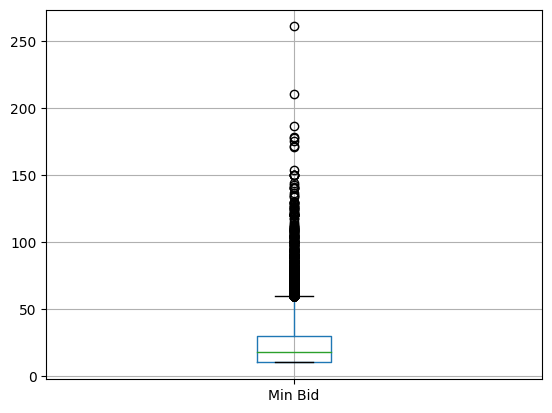

In [198]:
data.boxplot(column=['Min Bid'])
plt.show()

In [199]:
# Drop 'After Process Vacancy' column as it is future dependent.
data = data.drop(columns=['After Process Vacancy'], errors='ignore')

In [200]:
data.dtypes

Term                       object
Description                object
Section                    object
Vacancy                     int64
Before Process Vacancy      int64
Median Bid                float64
Min Bid                   float64
Instructor                 object
Grading Basis              object
class1_day                 object
class1_starttime           object
class1_venue               object
class2_day                 object
class2_starttime           object
class2_venue               object
class3_day                 object
class3_starttime           object
class3_venue               object
exam_startdate             object
exam_day                   object
exam_starttime             object
AY                          int64
Incoming Freshman          object
Incoming Exchange          object
Round                      object
Window                      int64
SubjectArea                object
CatalogueNo                object
dtype: object


---
## 4. Save data into CSV
    

In [202]:
# Save the transformed data to a CSV file
output_path = 'transformed_data_w_timings_v3.csv'
data.to_csv(output_path, index=False)
print(f"Data successfully saved to {output_path}")

Data successfully saved to transformed_data_w_timings_v3.csv
